In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import gzip
from datetime import datetime, timedelta
from statistics import mean, median
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow
import tensorflow.keras as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Conv2D, Dropout
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
import csv
import random

from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

In [18]:
def retrieve_data(varname, filename):
    df = pd.read_csv(filename, index_col=0)
#     df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

def create_classification_data(df, lookback):
    rows = []
    columns = ['Date', 'NASDAQ_relative_change_perc_1'] # Date and SP500_relative_change_perc_1 from t-0 are added first as target variables 
    
    # create column names based on original with the addition of t-i where i is lookback
    for i in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
        new_columns = df.columns.tolist()[1:] # starts at 1 to exclude 'Date' column
        for x in range(len(new_columns)):
            new_columns[x] = new_columns[x] + "_t-" + str(i)
        columns = columns + new_columns
    
    # create lookback data
    for i, row in enumerate(df.iterrows()):
        if i > lookback: # lookback cannot be determined for earlier rows
            new_row = [row[1][0], row[1][1]] # add target 'Date' and 'SP500_relative_change_perc_1 '
            for x in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
                add_row = df.iloc[i - x].tolist()[1:] # starts at 1 to exclude 'Date' column
                new_row = new_row + add_row
            rows.append(new_row)
    df2 = pd.DataFrame(rows)
    df2.columns = columns
    return df2

def create_train_val_test(df, year_val, year_test, perc_train=None):
    if perc_train == None:
        # assumes years_train < year_val < year_test
        df["Date"] = pd.to_datetime(df["Date"])
        
        val = df[df['Date'].dt.year == year_val]
        test = df[df['Date'].dt.year == year_test]
        train = df[df['Date'].dt.year < year_val]
    else:
        train = df.head(round(len(df) * perc_train))
        val = df.tail(len(df) - len(train))
        test = val.tail(round(0.5 * len(val)))
        val = df.head(len(val) - len(test))
    y_train = train['NASDAQ_relative_change_perc_1']
    x_train = train.drop(['NASDAQ_relative_change_perc_1'], axis=1)
    
    y_val = val['NASDAQ_relative_change_perc_1']
    x_val = val.drop(['NASDAQ_relative_change_perc_1'], axis=1)
    
    y_test = test['NASDAQ_relative_change_perc_1']
    x_test = test.drop(['NASDAQ_relative_change_perc_1'], axis=1)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

def scale_data(x):
    standard_scaler = MinMaxScaler()
    x = x.drop(["Date"], axis=1)
    x_scaled = pd.DataFrame(standard_scaler.fit_transform(x), columns=x.columns)
    return x_scaled

In [32]:
lookback = 10
val_year = 2018
test_year = 2019

files = {
    # varname: filename
    "NASDAQ": "Dataset v3/NASDAQ_reduced_data_20220425.csv",
#     "S&P500": "Dataset v3/SP500_combined_data_20220422.csv"
}

for file in files:
    df = retrieve_data(file, files[file])

df = create_classification_data(df, lookback)

x_train, y_train, x_val, y_val, x_test, y_test = create_train_val_test(df, val_year, test_year)

In [33]:
y_train

0       0.003351
1       0.006484
2      -0.000621
3       0.009194
4       0.025268
5       0.011697
6       0.001664
7       0.009324
8       0.001242
9      -0.000962
10     -0.001121
11      0.005134
12      0.007479
13     -0.010623
14     -0.013030
15      0.001627
16      0.000402
17     -0.007723
18      0.014090
19      0.000040
20     -0.010106
21     -0.009434
22      0.007920
23      0.018543
24      0.011003
25      0.010374
26     -0.004013
27     -0.000671
28      0.001549
29      0.003176
          ...   
2100    0.007557
2101   -0.001716
2102    0.000211
2103    0.006148
2104   -0.000316
2105    0.001607
2106   -0.001653
2107    0.002704
2108   -0.012000
2109    0.003089
2110    0.000519
2111   -0.017655
2112    0.000454
2113    0.005089
2114    0.003994
2115   -0.002895
2116    0.004007
2117   -0.001513
2118   -0.000670
2119   -0.004481
2120    0.009464
2121    0.002057
2122   -0.003919
2123   -0.004334
2124   -0.001078
2125    0.000279
2126    0.001058
2127   -0.0003

In [34]:
def label_data(y):
    positives = []
    negatives = []
    y = list(y)
#     for dev in y:
#         if dev >= 0:
#             positives.append(dev)
#         else:
#             negatives.append(dev)
#     med_pos = median(positives)
#     med_neg = median(negatives)
    
    labels = []
    for dev in y:
        if dev >= 0:
            labels.append(1)
#             if dev >= med_pos:
#                 labels.append(2)
#             else:
#                 labels.append(1)
        else:
            labels.append(0)
#             if dev <= med_neg:
#                 labels.append(-2)
#             else:
#                 labels.append(-1)
    return labels
# 
y_train = label_data(y_train)
y_val = label_data(y_val)
y_test = label_data(y_test)

In [35]:
def random_baseline(y):
    counts = [0, 0]
    for i in y:
        if i == 0:
            counts[0] = counts[0] + 1
        elif i == 1:
            counts[1] = counts[1] + 1
    print(f"\tDistribution: {counts}")
    print(f"\tRandom baseline accuracy (majority class): {counts[np.argmax(np.asarray(counts))]/ len(y)}")
    
print("Random baseline training set")
random_baseline(y_train)
print("Random baseline validation set")
random_baseline(y_val)
print("Random baseline test set")
random_baseline(y_val)

Random baseline training set
	Distribution: [948, 1182]
	Random baseline accuracy (majority class): 0.5549295774647888
Random baseline validation set
	Distribution: [120, 131]
	Random baseline accuracy (majority class): 0.5219123505976095
Random baseline test set
	Distribution: [120, 131]
	Random baseline accuracy (majority class): 0.5219123505976095


In [36]:
train_date = x_train[['Date']]
x_train = x_train.drop(['Date'], axis=1)

val_date = x_val[['Date']]
x_val = x_val.drop(['Date'], axis=1)

test_date = x_test[['Date']]
x_test = x_test.drop(['Date'], axis=1)

In [37]:
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

print(x_train.shape, y_train.shape)

(2130, 180) (2130,)


In [38]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# y_train = to_categorical(y_train, 1)
# y_val = to_categorical(y_val, 1)
# y_test = to_categorical(y_test, 1)

y_train = y_train.reshape((y_train.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

In [39]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)


(2130, 1, 180) (2130, 1)
(251, 1, 180) (251, 1)
(252, 1, 180) (252, 1)


In [55]:
# RESULT OPT 3 LAYERS
# tensorflow.random.set_seed(111)
# np.random.seed(111)
# random.seed(111)
# # lookback = 4
# epochs = 390
# batch_size = 64
# model = Sequential()
# model.add(Dense(239, activation='sigmoid'))
# model.add(Dropout(0.17))
# model.add(Dense(353, activation='sigmoid'))
# model.add(Dropout(0.95))
# model.add(Dense(73, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# # RESULT OPT 2 LAYERS
# tensorflow.random.set_seed(111)
# np.random.seed(111)
# random.seed(111)
# # lookback = 15
# epochs = 429
# batch_size = 64
# model = Sequential()
# model.add(Dense(264, activation='sigmoid'))
# model.add(Dropout(0.52))
# model.add(Dense(88, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# # RESULT OPT 1 LAYER
tensorflow.random.set_seed(111)
np.random.seed(111)
random.seed(111)
# lookback = 10
epochs = 248
epochs = 51
batch_size = 64
model = Sequential()
model.add(Dense(420, activation='tanh'))
model.add(Dropout(0.17))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val), shuffle=False)

Epoch 1/51
34/34 [==============================] - 1s 6ms/step - loss: 0.9164 - acc: 0.5055 - val_loss: 0.7569 - val_acc: 0.5100
Epoch 2/51
34/34 [==============================] - 0s 2ms/step - loss: 0.7088 - acc: 0.5593 - val_loss: 0.7358 - val_acc: 0.4821
Epoch 3/51
34/34 [==============================] - 0s 2ms/step - loss: 0.6534 - acc: 0.6266 - val_loss: 0.7264 - val_acc: 0.5418
Epoch 4/51
34/34 [==============================] - 0s 2ms/step - loss: 0.6316 - acc: 0.6329 - val_loss: 0.7123 - val_acc: 0.5418
Epoch 5/51
34/34 [==============================] - 0s 2ms/step - loss: 0.6175 - acc: 0.6355 - val_loss: 0.7183 - val_acc: 0.5339
Epoch 6/51
34/34 [==============================] - 0s 2ms/step - loss: 0.5768 - acc: 0.6921 - val_loss: 0.7105 - val_acc: 0.5418
Epoch 7/51
34/34 [==============================] - 0s 2ms/step - loss: 0.5511 - acc: 0.7183 - val_loss: 0.6974 - val_acc: 0.5697
Epoch 8/51
34/34 [==============================] - 0s 2ms/step - loss: 0.5688 - acc: 0.70

In [56]:
model_file = "Models/NASDAQ_NN_up-down_model"
model.save(model_file)

2022-05-06 10:43:35.241140: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Models/NASDAQ_NN_up-down_model/assets


In [52]:
def evaluate_convergence(history):
    epochs = []
    for i in range(len(history.history['loss'])):
        epochs.append(i)
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig1 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig1.add_trace(go.Scatter(x=epochs, y=train_loss, mode="lines", name="Train Loss"), row=1, col=1)
    fig1.add_trace(go.Scatter(x=epochs, y=val_loss, mode="lines", name="Validation Loss"), row=1, col=1)
    fig1.update_layout(
        title = "Training and Validation Loss Convergence per Epoch", 
        xaxis1 = dict(title_text = "Epoch"),
        yaxis1 = dict(title_text = "Loss"),
    )
#     fig1.write_image()
    fig1.show()
    
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    fig2 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig2.add_trace(go.Scatter(x=epochs, y=train_acc, mode="lines", name="Training Accuracy"), row=1, col=1)
    fig2.add_trace(go.Scatter(x=epochs, y=val_acc, mode="lines", name="Validation Accuracy"), row=1, col=1)
    fig2.update_layout(
        title = "Training and Validation Accuracy Convergence per Epoch", 
        xaxis1 = dict(title_text = "Epoch"),
        yaxis1 = dict(title_text = "Accuracy"),
    )
#     fig2.write_image()
    fig2.show()
    
evaluate_convergence(history)

In [53]:
def evaluate(model, x, y):
    y = y.tolist()
    y_pred = model.predict(x)
    y_pred = y_pred.round()
    y_pred = y_pred.tolist()
    
    for i in range(len(y)):
        y[i] = int(y[i][0])
        y_pred[i] = int(y_pred[i][0][0])
    
    acc = accuracy(y, y_pred)
    print(f"\tAccuracy: {acc}")
    
    prec = precision(y, y_pred)
    print(f"\tPrecision: {prec}")
    
    rec = recall(y, y_pred)
    print(f"\tRecall: {rec}")
    
    f = f1(y, y_pred)
    print(f"\tF1-score: {f}")
    
print("Training set evaluation")
evaluate(model, x_train, y_train)
print("Validation set evaluation")
evaluate(model, x_val, y_val)
print("Test set evaluation")
evaluate(model, x_test, y_test)

Training set evaluation
	Accuracy: 0.8244131455399061
	Precision: 0.7927536231884058
	Recall: 0.9255499153976311
	F1-score: 0.8540202966432475
Validation set evaluation
	Accuracy: 0.5896414342629482
	Precision: 0.5909090909090909
	Recall: 0.6946564885496184
	F1-score: 0.6385964912280702
Test set evaluation
	Accuracy: 0.5
	Precision: 0.538961038961039
	Recall: 0.6014492753623188
	F1-score: 0.5684931506849316


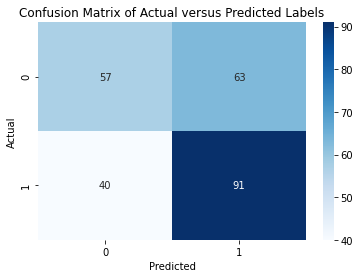

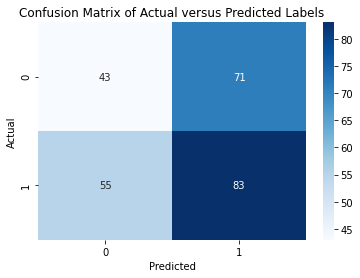

In [54]:
def confusion_matrix(model, x, y):
    y_pred = model.predict(x, batch_size=1)

    originals = []
    predictions = []

    for i in range(len(y_pred)):
        originals.append(y[i][0])
        predictions.append(round(float(y_pred[i][0])))
        
    df = pd.DataFrame()
    df['Actual'] = originals
    df['Predicted'] = predictions
    
    conf_matrix = pd.crosstab(df['Actual'], df['Predicted'])
    sns.heatmap(conf_matrix, annot=True, cmap='Blues')
    plt.title("Confusion Matrix of Actual versus Predicted Labels")
    plt.show()
    
# confusion_matrix(model, x_train, y_train)
confusion_matrix(model, x_val, y_val)
confusion_matrix(model, x_test, y_test)

In [16]:
def retrieve_candles(filename, val_year, test_year):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    df.columns = ["Date", "Close", "Open", "High", "Low", "Vol.", "Change%"]
    df = df.sort_values('Date', ascending=True)
    
    candles_val = df[df['Date'].dt.year == val_year]
    candles_train = df[df['Date'].dt.year < val_year]
    candles_train = candles_train[candles_train['Date'] > datetime(2009,7,10)]
    
    candles_train = candles_train.replace(',','', regex=True)
    candles_val = candles_val.replace(',','', regex=True)

    return candles_train, candles_val

def plot_predictions_candles(x, y, df, dataset):
    # PREDICTIONS LIJKEN NOG NIET GOED UITGELIJND MET CANDLES???
    originals = []
    predictions = []
    y_pred = model.predict(x)
    for i in range(len(y_pred)):
        originals.append(y[i][0])
        predictions.append(round(float(y_pred[i][0])))

    fig = go.Figure()
    fig.add_trace(go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name="Price"))
    standard_factor = 0.5 * mean([float(df.iloc[0].tolist()[3]), float(df.iloc[0].tolist()[4])])
    
    green_legend = False
    orange_legend = False
    red_legend = False
    
    for i, row in enumerate(df.iterrows()):
        pred_date = row[1][0].to_pydatetime()
        pred_high = float(row[1][3])
        pred_low = float(row[1][4])
#         real_label = row[1][7]
#         pred_label = row[1][8]
        real_label = originals[i]
        pred_label = predictions[i]
        
        start_shape = pred_date - timedelta(days=0.1)
        end_shape = pred_date + timedelta(days=0.1)
    
        
        if pred_label == 1:
            extreme = pred_high + 0.1 * standard_factor
            standard = pred_high + 0.05 * standard_factor
#         elif pred_label == 2:
#             extreme = pred_high + 0.2 * standard_factor
#             standard = pred_high + 0.05 * standard_factor
        elif pred_label == 0:
            extreme = pred_low - 0.1 * standard_factor
            standard = pred_low -  0.05 * standard_factor
#         elif pred_label == -2:
#             extreme = pred_low - 0.2 * standard_factor
#             standard = pred_low - 0.05 * standard_factor
            
        if real_label == pred_label:
            color = "green"
#         elif np.sign(real_label) == np.sign(pred_label):
#             color = "orange"
        else:
            color = "red"
        
        if real_label == pred_label and not green_legend:
            green_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Correct Direction", mode="lines", line=dict(color=color)))
        
#         elif np.sign(real_label) == np.sign(pred_label) and not orange_legend:
#             orange_legend = True
#             fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
#                                  y=[standard,extreme,standard,standard], 
#                                  fill="toself", name="Correct Direction / Inorrect Magnitude", mode="lines", line=dict(color=color)))
        elif real_label != pred_label and not red_legend:
            red_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Incorrect Direction", mode="lines", line=dict(color=color)))
        else:
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", showlegend=False, mode="lines", line=dict(color=color)))
    
    title = f"Visualization of {dataset} Predictions"
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    layout = dict(title=title, height=800, width=1500)
    fig.update_layout(layout)
#     config = dict({'scrollZoom': True})
#     fig.show(config=config)
    fig.show()

filename = "Dataset v3/Indices/S&P 500 Historical Data.csv"
candles_train, candles_val = retrieve_candles(filename, val_year, test_year) 
# plot_predictions_candles(x_train, y_train, candles_train, "Training")
plot_predictions_candles(x_val, y_val, candles_val, "Validation")